# Esercitazione 6
### Laboratorio di Simulazione Numerica

Il materiale dell'esercitazione sei di LSN è raccolto nella cartella `Lab_06`. Il codice è raccolto nella cartella `Code/6.1`. I risultati presentati in questa relazione sono conservati nella cartella `Results`.

---

Il Jupyter Notebook è organizzato nel modo seguente:
- 6.0 caricamento dei pacchetti e introduzione;
- 6.1 completamento del codice `Monte_Carlo_Ising_1D.cpp/h` con l'aggiunta dei metodi per implementare Metropolis e Gibbs, stima dell'andamento delle grandezze di interesse nel range di temperatura $T\in [0.5,2]$.

## 6.0 - caricamento dei pacchetti e introduzione

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set_theme(font_scale=2, style='whitegrid') 

__NB:__ nel paragrafo seguente ho imposto $\mu_B=1=k_B.$

---

In questa esercitazione utilizziamo un codice nel quale implementiamo un modello di Ising. Quello di Ising è un modello per un magnete, nel quale consideriamo un certo numero di spin $s_i$, con $i=1,..,N$ disposti su un reticolo e potenti assumere valore $+1$ o $-1$. In questa sede, per semplicità, consideriamo un modello monodimensionale. 
Esistono dunque $2^N$ stati possibili per il sistema, ciascuno dei quali avente energia rappresentata dall'hamiltoniana di Ising:

$$ H = -J \sum_{i=1}^N s_i s_{i+1} - \frac{h}{2} \sum_i (s_i+s_{i+1}), $$ 

dove consideriamo soltanto le interazioni tra __primi vicini__ e indichiamo con $J$ l'energia di interazione tra spin e $h$ l'eventuale campo magnetico esterno.

---

Noi siamo interessati a stimare il valore di alcune grandezze macroscopiche del magnete: energia interna per particella $U/N$, capacità termica media per sito $C/N$, suscettività magnetica $\chi$ e magnetizzazione media per particella $M/N$ al variare del valore della temperatura $T$. 

Al contempo, dato che tratteremo il sistema sotto assunzione di _ensamble canonico_ (numero di particelle $N$, temperatura $T$ e volume $V$ fissati),  dovremo effettuare tante misure quanti valori di $T$ fisseremo.

---

Assumiamo allora di aver fissato la temperatura $T\equiv 1/\beta$. La densità di probabilità di occupazione dello stato $\nu$ in _ensamble canonico_ è data dalla distribuzione di Blotzmann:

$$ \rho(\nu) = \frac{\texttt{exp}\bigl[-\beta H_{\nu} \bigr]}{\sum_{\mu}\texttt{exp}\bigl[-\beta H_{\mu} \bigr]}. $$

Abbiamo dunque una distribuzione densità di probabilità da campionare necessariamente per ricostruire il sistema di spin e poter misurare le grandezze macroscopiche: ci serve un algoritmo di campionamento.

---

Abbiamo utilizzato due approcci: algoritmo di Metropolis e algoritmo di Gibbs. 

In entrambi i casi partiamo da una configurazione iniziale degli spin, letta dal file `config.0`. L'inizializzazione del processo è implementata nel metodo `prepare_initial_config(string init_condition, "config.0")`, nel quale è possibile impostare il valore della variabile di tipo stringa come `init_condition = "T=0"` oppure `init_condition = "T=inf"`; nel primo dei casi, che corrisponde al _ground state_, tutti gli spin vengono orientati nello stesso modo (ho scelto $s_i=+1$), nel secondo il valore dello spin in ogni sito viene assegnato in modo casuale con probabilità $p=0.5$. 

Entriamo ora nel merito degli algoritmi di campionamento. Viene selezionato in modo casuale uno dei siti del reticolo (ad esempio il $k$-esimo) e: 
- __Metropolis:__ si cambia il suo valore ($\pm 1 \to \mp 1$). In termini della notazione introdotta nell'esercitazione precedente, indicando con $\mu$ e $\nu$ rispettivamente lo stato vecchio e lo stato nuovo del sistema. Si effettua $T(\mu\to\nu)$, scegliendo un nucleo stocastico tale che sia vero che $T(\mu\to\nu)=T(\nu\to\mu)$. La probabilità che questa modifica venga accettata è:$$ A(\mu\to\nu)=\min\biggl[ 1, \frac{T(\nu\to\mu)p(\nu)}{T(\mu\to\nu)p(\mu)} \biggr] = \min\biggl[1, e^{-\beta (E_{\nu}-E_{\mu})} \biggr]. $$ Questa scelta consente di accettare sempre le nuove configuarazioni tali che $E_{\nu}-E_{\mu}\equiv\Delta E \leq 0$ e accettare con probabilità $e^{-\beta \Delta E}$ quelle in cui si ha invece $\Delta E > 0$;
- __Gibbs:__ si aggiorna il valore dello spin $k$-esimo in funzione del valore che assumono i suoi prossimi vicini. La probabilità che tale spin venga posto uguale a $\pm 1$ nella nuova configurazione ($\nu$) è data da: $$ p\biggl(s^{\nu}_k\to\pm1|\{ s_j^{\mu} \text{t.c.} j\neq k\}\biggr) = \biggl( 1+\text{exp}\bigl[\mp 2\beta \bigl(J\sum_{n.n.} s_i^{\mu}+h\bigr)\bigr]\biggr)^{-1} $$ Nel campionamento "alla Gibbs", infatti, ciò che si deve stabilire è semplicemente il nuovo valore dello spin e il il cambiamento viene sempre accettato.

Nell'implementazione di entrambi gli algoritmi abbiamo utilizzato delle _periodic boundary conditions_ (PBC), tali che $s_{N+1} = s_1$ e non si presentino problemi legati alla dimensione finita del campione di spin.

---

Gli algoritmi di Metropolis e Gibbs ci consentono di campionare lo spazio delle configurazioni del reticolo e, nel farlo, possiamo effettuare più volte le misure delle grandezze medie a cui siamo interessati. Una volta terminato il processo di campionamento, possiamo utilizzare l'insieme di misure raccolto per stimare definitivamente tali grandezze utilizzando il metodo delle medie a blocchi.

## 6.1 - completamento del codice e stima delle grandezze di interesse per $T\in[0.5,2]$

### Equilibrare il sistema

Come già spiegato nel notebook relativo all'esercitazione cinque, quando si esegue un campionamento utilizzando $M(RT)^2$ è importante equilibrare il sistema. Per farlo, si eseguono "a vuoto" $N_{equi}$ passi dell'algoritmo, i quali non vengono coinvolti nella stima delle grandezze. In questo codice ho implementato la fase di equilibrazione all'interno del metodo `Equilibrate_system(int Nequi)`, dove `Nequi` è il numero di passi con cui intendiamo equilibrare il sistema.

---

### I due tipi di campionamento

All'interno del codice le mosse con cui eseguiamo il campionamento sono implementate nel metodo `Move(int metro)`. A seconda del valore fornito tramite la variabile `metro` vengono eseguiti campionamenti tramite Metropolis (`metro = 1`) o Gibbs (`metro = 0`). Questo valore viene letto dal file `input.file`. 

---

Come prima cosa ho voluto visualizzare i valori istantanei dell'energia interna media per sito, per controllare se il processo di equilibrazione garantisce la convergenza del sistema attorno all'energia con cui lo vincoliamo. Per questa prima fase di controllo ho eseguito `Nequi=1'000` passi di equilibrazione a partire da uno stato disordinato (`init_condition = "T=inf"`). A seguire ho stampato i valori istantanei di $U/N$ (dei quali mostro solo l'ultimo valore istantaneo registrato in un blocco) e li ho utilizzati per stimare con il metodo della media a blocchi il valore della stessa grandezza e la sua incertezza utilizzando `Nstep = 10'000` passi per blocco e `Nblk = 100` blocchi. Per verificare il comportamento del sistema a varie temperature ho eseguito questo primo procedimento per $T=0.5$, $T=1.25$, $T=2.0$.

#### Energia interna per testare l'equilibrazione

In [3]:
ene05_M   = np.loadtxt("Results/ene100_T_05_M.0")
ene05_G   = np.loadtxt("Results/ene100_T_05_G.0")
ene2_M    = np.loadtxt("Results/ene100_T_2_M.0")
ene2_G    = np.loadtxt("Results/ene100_T_2_G.0")
ene125_M  = np.loadtxt("Results/ene100_T_1.25_M.0")
ene125_G  = np.loadtxt("Results/ene100_T_1.25_G.0")

#### Caricamento dei risultati

In [4]:
ene_metro  = np.loadtxt("Results/ene_metro.0")
#ene_metro  = np.loadtxt("output.ene.0")
heat_metro = np.loadtxt("Results/heat_metro.0")
chi_metro  = np.loadtxt("Results/chi_metro.0")
ene_gibbs  = np.loadtxt("Results/ene_gibbs.0")
heat_gibbs = np.loadtxt("Results/heat_gibbs.0")
chi_gibbs  = np.loadtxt("Results/chi_gibbs.0")
M_metro    = np.loadtxt("Results/MAGMET.0")
M_gibbs    = np.loadtxt("Results/MAGGIBBS.0")


test = np.loadtxt("Results/test.0")
heat_G = np.loadtxt("Results/heat_G_20.0")

G = np.loadtxt("Results/MAGGIBBS.0")
M = np.loadtxt("Results/MAGMET.0")

xx = np.arange(151)

In [5]:
def get_ene(T):
    beta = 1/T
    J = 1.0
    Ns = 50
    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th
    e = -J*( th + ch*thN )/( 1 + thN )
    x_mean = np.linspace(0,np.max(ene_metro.T[0]))
    y_mean = x_mean*0 + e 
    return e

In [6]:
def plot_ene(ene_list, ene_gibb, cotitle, temp, col1, col2, sup):
    
    plt.figure(figsize=(22,8))
    if(sup==0): plt.suptitle("Ultime misure istantanee per blocco e prime stime")
    
    x = np.arange(100)

    plt.subplot(1,2,1)
    plt.title("Valore istantaneo dell'energia interna "+cotitle)
    plt.plot(ene_list.T[1], color=col1, alpha=0.5, linewidth=3, label='Metropolis')
    plt.plot(ene_gibb.T[1], color=col2, alpha=0.5, linewidth=3, label='Gibbs')
    plt.hlines(get_ene(temp),0,101, color='black', linewidth=2, alpha=0.8, label='Valore teorico')
    plt.xlabel('lanci ($\cdot 10^4)$')
    plt.ylabel('$U_{int}/N$')
    plt.legend()

    plt.subplot(1,2,2)
    plt.title("Stima dell'energia interna con data blocking "+ cotitle)
    plt.errorbar(x, ene_list.T[2], yerr=ene_list.T[3], color=col1, alpha=0.5, label='Metropolis', linewidth=2)
    plt.errorbar(x, ene_gibb.T[2], yerr=ene_gibb.T[3], color=col2, alpha=0.5, label='Gibbs', linewidth=2)
    plt.hlines(get_ene(temp),0,101, color='black', linestyle='-', label="Valore teorico", linewidth=2, alpha=0.8)
    plt.ylabel("$U_{int}/N$")
    plt.xlabel("$N_{blocchi}$")
    plt.legend()
    plt.tight_layout()

    plt.show()

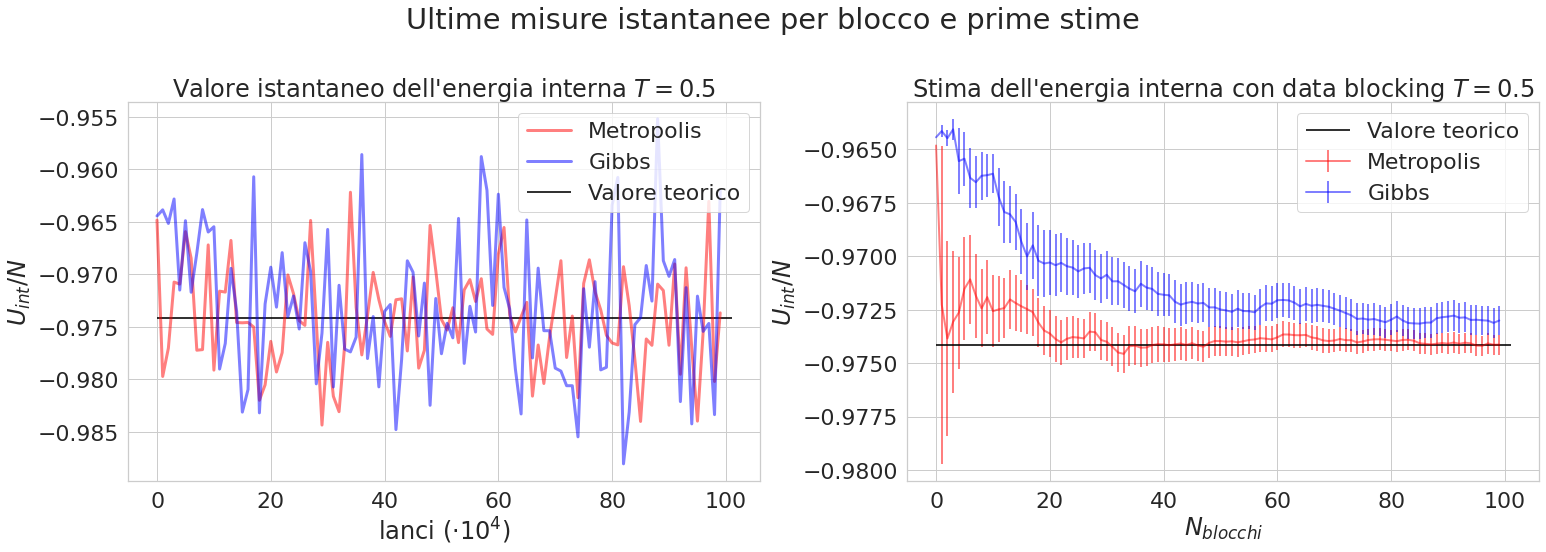

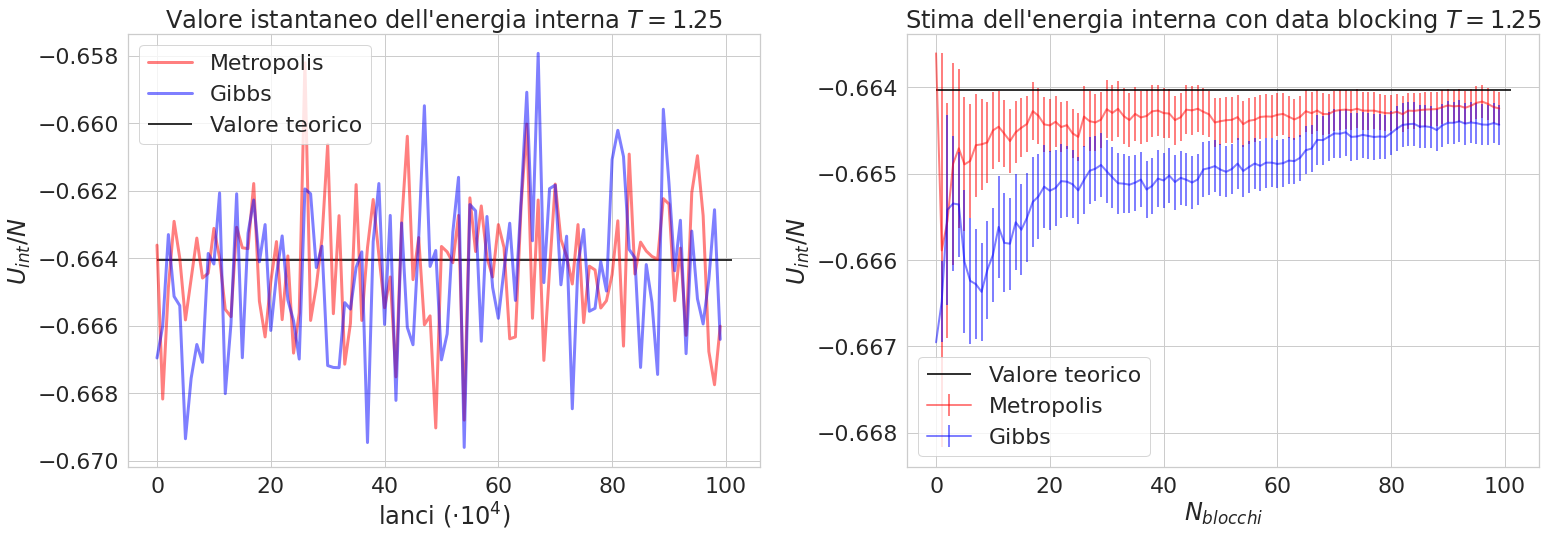

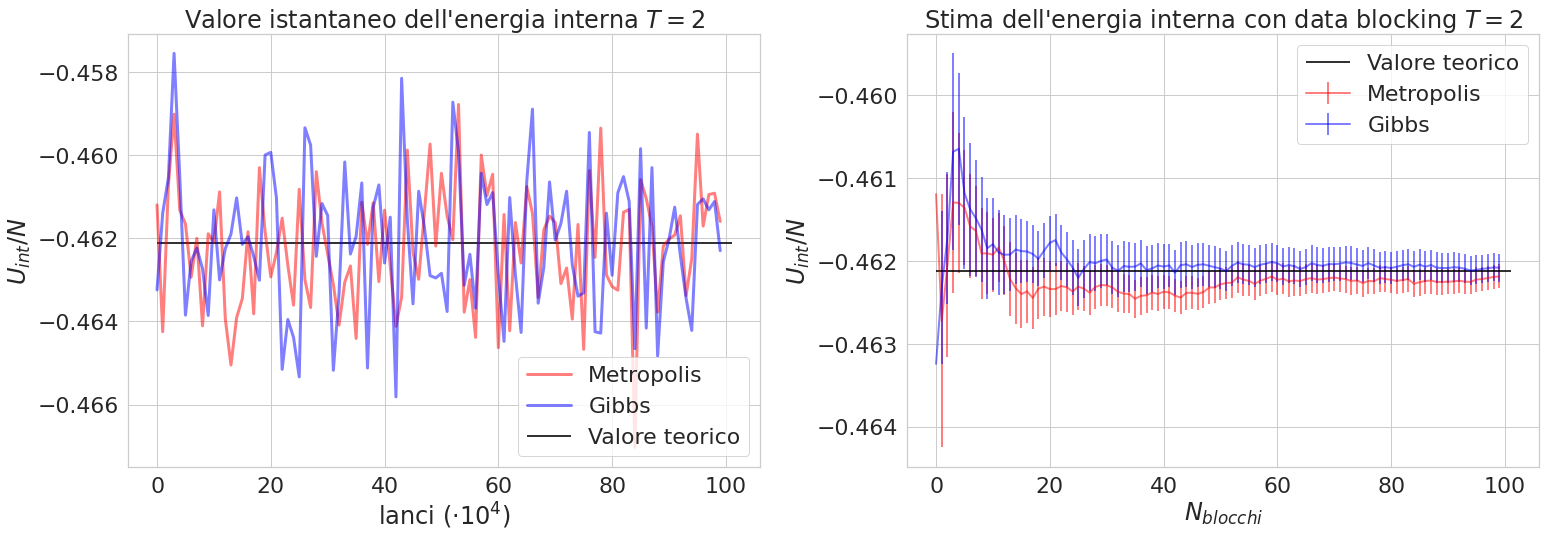

In [7]:
plot_ene(ene05_M, ene05_G, r"$T=0.5$", 0.5, 'red', 'blue', 0)
plot_ene(ene125_M, ene125_G, r"$T=1.25$", 1.25, 'red', 'blue', 1)
plot_ene(ene2_M, ene2_G, r"$T=2$", 2, 'red', 'blue', 1)

__Figura 1:__ a sinistra, alcuni dei valori istantanei registrati per $U/N$ (in rosso il Metropolis, in blu il Gibbs). Ho limitato il numero di dati per poter visualizzare meglio le oscillazioni: si vede come i valori siano dispersi attorno al valore teorico rappresentato in nero nelle figure. A destra, stima del valore di $U/N$ e della sua incertezza tramite metodo delle medie a blocchi. Ho eseguito questo controllo per tre diverse temperature: dall'alto verso il basso $T=0.5$, $T=1.25$, $T=2.0$. Il sistema riesce ad equilibrarsi in qualsiasi temperatura anche successivamente a pochi passi di equilibrazione.

---

Per quanto riguarda la stima e l'analisi delle altre grandezze ho lavorato nel modo seguente:
1. ho suddiviso il range di temperatura $[0.5,2]$ in 150 passi dal valore `stepT = 0.01`. 
2. ho eseguito una stima delle grandezze __per ogni__ valore della temperatura $T\in [0.5,2]$ utilizzando il _blocking_. Ho deciso di impostare `Nstep = 100'000` passi per ciascun blocco ed eseguire il metodo utilizzando `Nblks = 20` blocchi.
3. ho salvato su file di output soltanto l'ultimo valore ottenuto, essendo a tutti gli effetti la stima migliore della grandezza in esame alla temperatura fissata;
4. ho rappresentato i risultati ottenuti in quattro grafici (uno per ciascuna grandezza), nei quali ho disegnato anche la curva teorica ottenuta risolvendo analiticamente il modello di Ising a primi vicini (è possibile farlo nel caso 1D). 

Nei seguenti paragrafi riporterò la soluzione analitica di riferimento e i risultati per ciascuna delle quattro grandezze.

---

__Nota sulle basse temperature:__ faccio due considerazioni prima di esporre i risultati relativi alle misure, così che valgano da commento per i numerosi grafici che seguono. Si noterà immediatamente che la tendenza degli algoritmi è quella di commettere errori molto maggiori nella stima delle grandezze (tutte) quando la temperatura si abbassa:
- l'algoritmo di Metropolis esegue un campionamento del sistema basando il processo di accettazione dei nuovi punti sulla densità di probabilità di Boltzmann. Questo implica che, al diminuire della temperatura, diventi sempre più difficile accettare nuovi punti. In sostanza, per temperature basse, il campionamento è rallentato, oltre che ridotto dal punto di vista quantitativo. Possiamo notare questo comportamento stampando a video il valore del tasso di accettazione nei blocchi durante la simulazione: nel caso di $T=0.5$ è circa del 2%! Già solo considerando una temperatura di $T=1.25$ passiamo ad un'accettazione media del 33% circa.
- nel caso del Gibbs possiamo fare un discorso differente. Lo spin della particella target viene stabilito esclusivamente in funzione di quello delle particelle prime vicine: potrebbe essere conservato oppure cambiato di segno. Assumiamo che i due primi vicini dello spin $k$-esimo siano concordi (entrambi $+1$ o $-1$). Eseguendo alcune verifiche possiamo notare come, all'aumentare della temperatura, aumenta la probabilità che lo spin $k$-esimo abbia orientamento diverso da quello dei suoi primi vicini. Al contrario, si nota come al diminuire della temperatura la probabilità che lo spin assuma esattamente il valore dei due suoi primi vicini è prossima a uno. Questo significa che il sistema di spin tende a clusterizzare avvicinandoci alle basse temperature. Il campionamento di Gibbs, allora, inizia a fornire variazioni sempre meno frequenti alla configurazione del sistema. Questo si traduce in una perdita di ricchezza di informazione paragonabile a quella registrata dal Metropolis (i grafici degli errori nelle successive celle lo dimostrano).  


### Energia interna media per sito

Stima dell'energia interna media per sito impostando $J=1, h=0$.

$$
\frac{U(N,T)}{N} = \frac{\langle H \rangle}{N}
= \frac{1}{N} \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}
= -\frac{1}{N}\frac{\partial \ln Z}{\partial \beta}
\underset{h=0}= -J \tanh (\beta J) \Biggl( \frac{1 + \tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

In [8]:
def show_errors(temp, true, metro, gibbs, title):
    plt.figure(figsize=(18,7))
    plt.title('Differenza tra valori stimati e valore teorico - '+title)
    plt.plot(T, metro.T[2]-true, linestyle=' ', marker='.', markersize=10, color='red', alpha=0.6, label='Metropolis')
    plt.plot(T, gibbs.T[2]-true, linestyle=' ', marker='.', markersize=10, color='blue', alpha=0.6, label ='Gibbs')
    for i in range(len(true)):
        plt.vlines(temp[i], 0, metro.T[2][i]-true[i], color='black')
        plt.vlines(temp[i], 0, gibbs.T[2][i]-true[i], color='black')
    plt.legend()
    plt.xlabel('T')
    plt.ylabel('Errori')
    plt.show()
    

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

T = np.linspace(0.5,2.0,num=151)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )

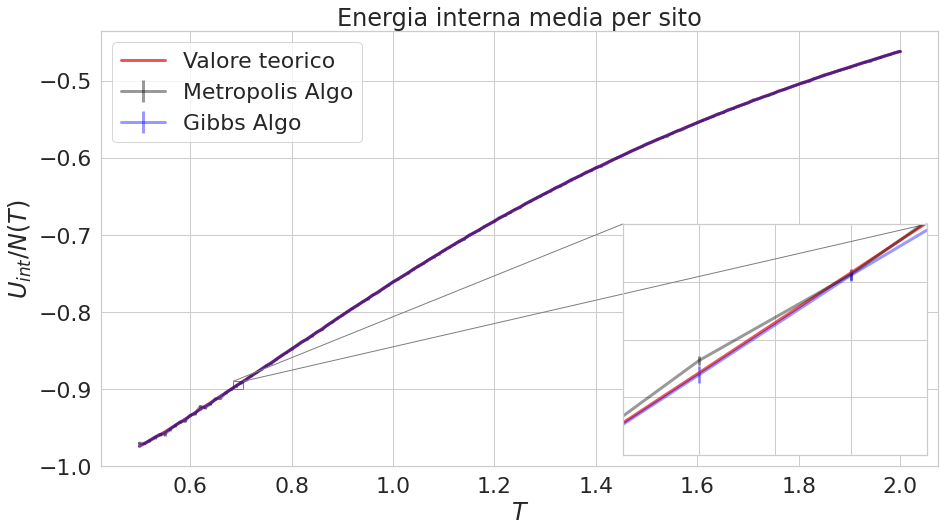

In [15]:
fig, ax = plt.subplots(figsize=[15, 8])
plt.title("Energia interna media per sito")
plt.ylabel("$U_{int}/N (T)$")
plt.xlabel("$T$")

x1, x2, y1, y2 = 0.685, 0.705, -0.9,-0.89
axins = zoomed_inset_axes(ax, zoom=30, loc=4)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

ax.plot(T, e, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
axins.plot(T, e, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
ax.errorbar(T, test.T[2], yerr=test.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
axins.errorbar(T, ene_metro.T[2], yerr=ene_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
ax.errorbar(T, ene_gibbs.T[2], yerr=ene_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')
axins.errorbar(T, ene_gibbs.T[2], yerr=ene_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

ax.legend()
plt.show()

__Figura 2:__ notiamo che al diminuire della temperatura si registra una diminuzione anche dell'energia media per sito: il sistema si sta raffreddando e tende a raggiungere una configurazione più stabile (gli spin si stanno allineando). 

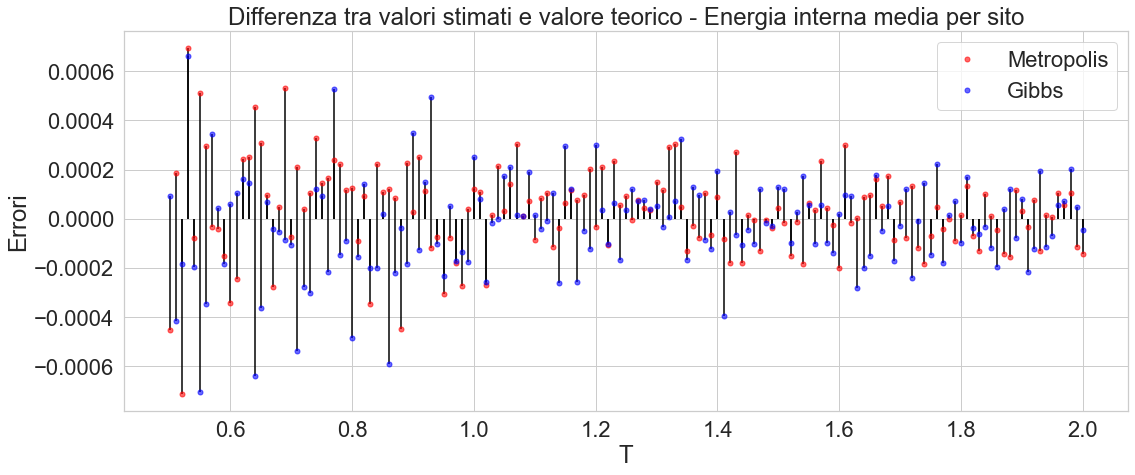

In [102]:
show_errors(T, e, ene_metro, ene_gibbs, 'Energia interna media per sito')

__Figura 3:__ gli errori commessi nella stima della grandezza tramite i due metodi sono paragonabili a temperature fissate. Risulta più complessa, indipendentemente dal metodo, la misura dei valori di energia interna a temperature più basse. 

### Calore specifico medio per sito
Stima del calore specifico medio per sito impostando $J=1, h=0$.

$$
\frac{C(N,T)}{N} = \frac{1}{N}\frac{\partial U(N,T)}{\partial T} 
\underset{h=0}= 
k_B (\beta J)^2 \left\{ 1+\tanh^N (\beta J)+(N-1)\tanh^2 (\beta J)+(N-1)\frac{\tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)}
- N \left[ \frac{\tanh (\beta J) + \tanh^{N-1} (\beta J)}{1+\tanh^N (\beta J)} \right]^2 \right\}
$$

In [103]:
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

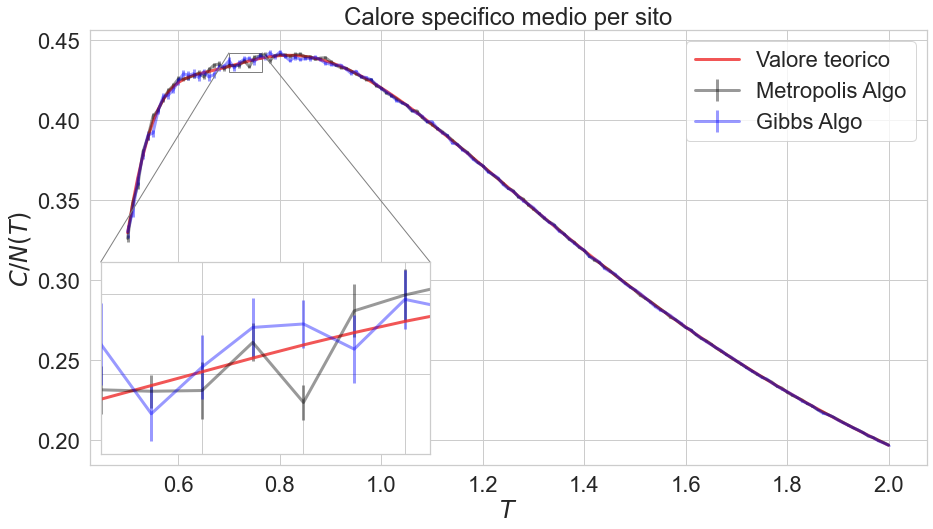

In [73]:
fig, ax = plt.subplots(figsize=[15, 8])
plt.title("Calore specifico medio per sito")
plt.ylabel("$C/N (T)$")
plt.xlabel("$T$")

x1, x2, y1, y2 = 0.70, 0.765, 0.43, 0.442
axins = zoomed_inset_axes(ax, zoom=10, loc=3)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

ax.plot(T, heat, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
axins.plot(T, heat, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
ax.errorbar(T, heat_metro.T[2], yerr=heat_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
axins.errorbar(T, heat_metro.T[2], yerr=heat_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
ax.errorbar(T, heat_gibbs.T[2], yerr=heat_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')
axins.errorbar(T, heat_gibbs.T[2], yerr=heat_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

ax.legend()
plt.show()

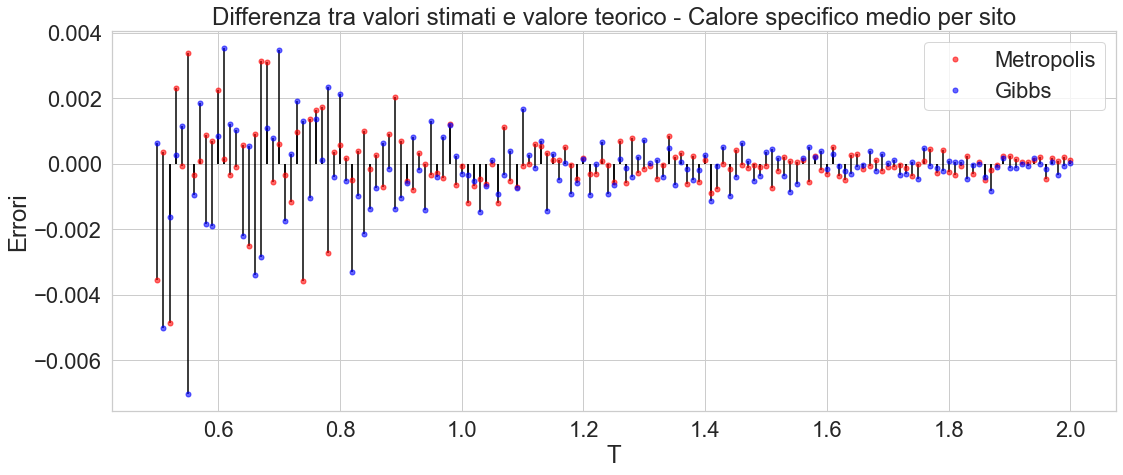

In [104]:
show_errors(T, heat, heat_metro, heat_gibbs, 'Calore specifico medio per sito')

__Figure 4,5:__ anche in questo caso i valori più critici da misurare sono quelli corrispondenti alle basse energie. Come abbiamo già detto, per questi valori di temperatura i due algoritmi registrano dei problemi nel compiere il campionamento in modo adeguato.

### Suscettività magnetica

Stima del valore della suscettività magnetica nel caso in cui $J=1, h=0$.

$$
\chi(N,T) = \frac{\partial M}{\partial h} = 
\frac{\partial}{\partial h}\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z} =\\
= \beta\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right]^2 \frac{\exp \left( -\beta H\right)}{Z}
-\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z}
\frac{1}{Z}\frac{\partial Z}{\partial h} = 
\beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle - \left\langle \sum_{i=1,N}s_i \right\rangle^2 \right] = \\
\underset{h=0}= \beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle \right] = \beta e^{2\beta J} \Biggl( \frac{1-\tanh^N (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

In [105]:
chi = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
#chi_gibbs

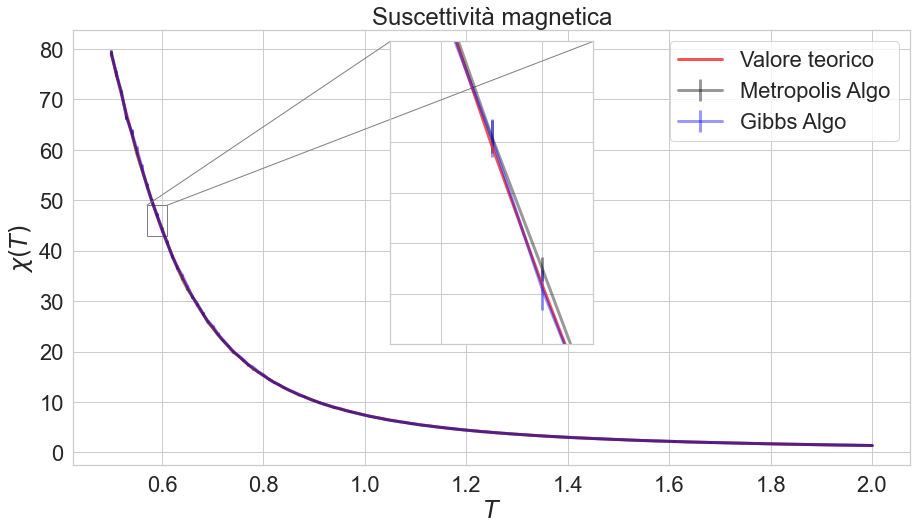

In [115]:
fig, ax = plt.subplots(figsize=[15, 8])
plt.title("Suscettività magnetica")
plt.ylabel("$\chi (T)$")
plt.xlabel("$T$")
#plt.errorbar(T, ene_G.T[2], yerr=ene_G.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')

x1, x2, y1, y2 = 0.57, 0.61, 43, 49
axins = zoomed_inset_axes(ax, zoom=10, loc=9)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

ax.plot(T, chi, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
axins.plot(T, chi, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
ax.errorbar(T, chi_metro.T[2], yerr=chi_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
axins.errorbar(T, chi_metro.T[2], yerr=chi_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
ax.errorbar(T, chi_gibbs.T[2], yerr=chi_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')
axins.errorbar(T, chi_gibbs.T[2], yerr=chi_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

ax.legend()
plt.show()

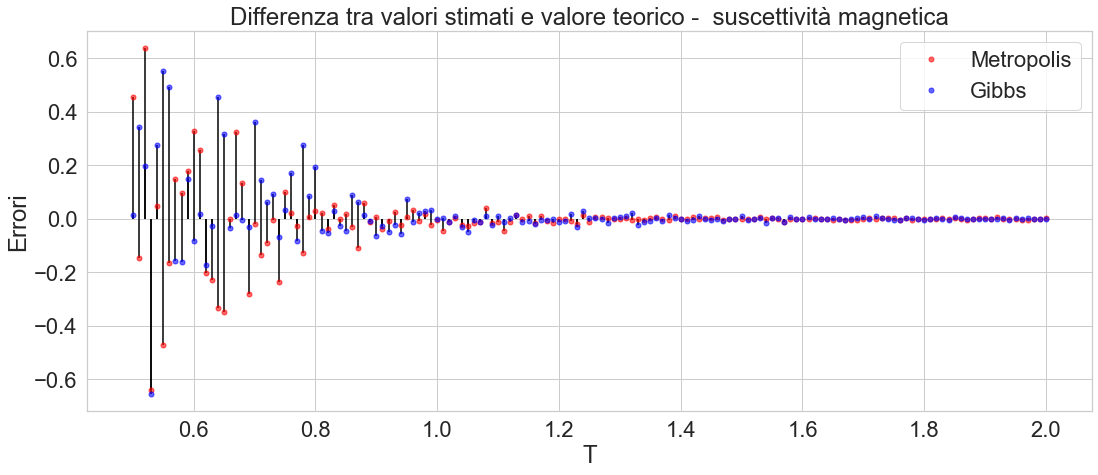

In [106]:
show_errors(T, chi, chi_metro, chi_gibbs, ' suscettività magnetica')

__Fig 6,7:__ commento analogo ai precedenti. La differenza tra gli errori a bassa temperatura e nelle altre zone del range è ancora maggiore rispetto ai due casi visti sopra. 

### Magnetizzazione media per sito

Stima della magnetizzazione media per sito. In questo caso è importante imporre che $h\neq 0$; consideriamo $J=1, h=0.02$.

$$
\frac{M(N,T,h)}{N}=\frac{e^{\beta J}\; \sinh(\beta h)}{Z} \; \Bigl[\lambda_1^{N-1}\cdot \Bigl(1+\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr) + \lambda_2^{N-1}\cdot \Bigl(1-\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr)\Bigr]
$$

In [125]:
# Soluzione analitica
h=0.02 # Campo esterno
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns

M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

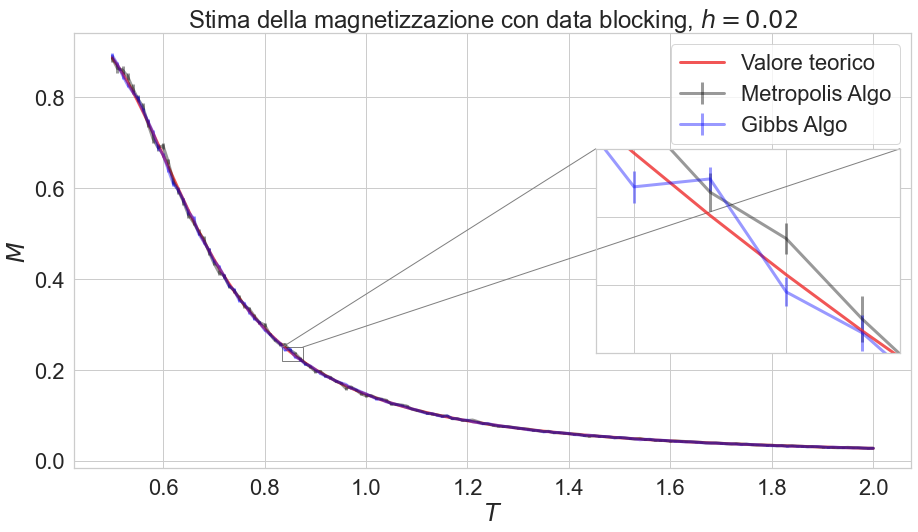

In [126]:
fig, ax = plt.subplots(figsize=[15, 8])
plt.title("Stima della magnetizzazione con data blocking, $h=0.02$")
plt.ylabel("$M$")
plt.xlabel("$T$")

x1, x2, y1, y2 = 0.835, 0.875, 0.22, 0.25
axins = zoomed_inset_axes(ax, zoom=15, loc=5)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

ax.plot(T, M, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
axins.plot(T, M, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
ax.errorbar(T, M_metro.T[2], yerr=M_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
axins.errorbar(T, M_metro.T[2], yerr=M_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
ax.errorbar(T, M_gibbs.T[2], yerr=M_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')
axins.errorbar(T, M_gibbs.T[2], yerr=M_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

ax.legend()
plt.show()

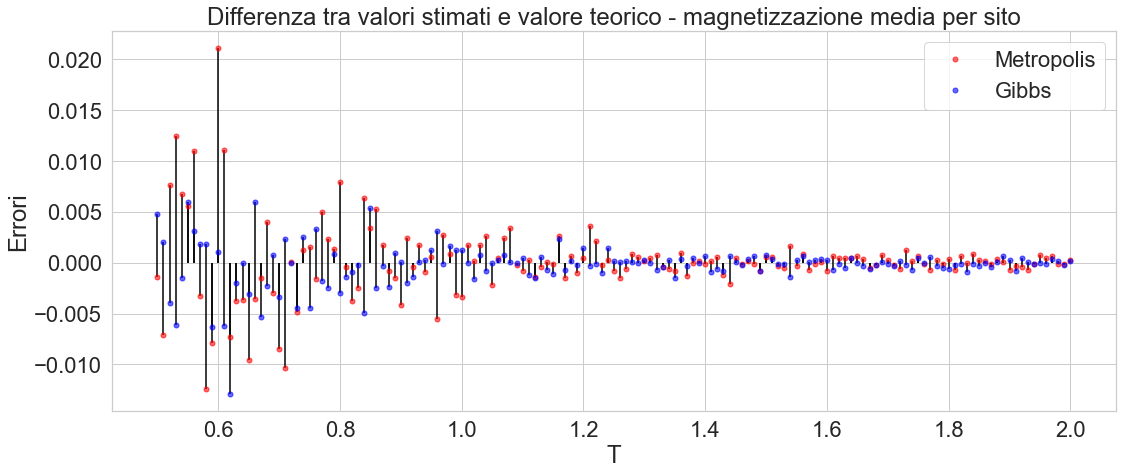

In [127]:
show_errors(T, M, M_metro, M_gibbs, 'magnetizzazione media per sito')

__Figura 8,9:__ i commenti sono analoghi ai precedenti.